# Cellular automata for the somatic evolution of breast cancer cells

**M1 GENIOMHE - Univ Evry Paris-Saclay (2024-2025)**

- Minh Ngoc VU

- Erine Benoist

This notebook is a supplementary material for the our final report for our course ***Modeling and simulation of biological system***. We reproduced the cellular automaton described in the paper "Cellular adaptations to hypoxia and acidosis during somatic evolution of breast cancer" (Gatenby, Robert A., et al., British journal of cancer 97.5 (2007): 646-653)

The figures included in our report are generated using this notebook.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font',**{'family':'serif','serif':['Helvetica']})
rc('text', usetex=False)

import os

from cellularautomata_BC import GenerateCA_BC

## Initializing the metabolite field

In [9]:
g_base = 1.0 
c_base = 1.0
h_base = 0.0
cellcolors = {('empty', (0.0, 0.0, 0.0, (None, None))): 'white', 
              ('normal', (g_base, g_base, h_base, (None, None))): 'grey', 
              ('H', (None, None, None, (None, None))): '#f38e8d',    # pink
              ('G', (None, None, None, (None, None))): '#09a44c',    # green
              ('GH', (None, None, None, (None, None))): '#09a44c',   # green
              ('A', (None, None, None, (None, None))): '#56529e',    # blue
              ('AH', (None, None, None, (None, None))): '#56529e',   # blue
              ('AG', (None, None, None, (None, None))): 'yellow', 
              ('AGH', (None, None, None, (None, None))): 'black'} 

ca_grid = GenerateCA_BC(50, cellcolors)

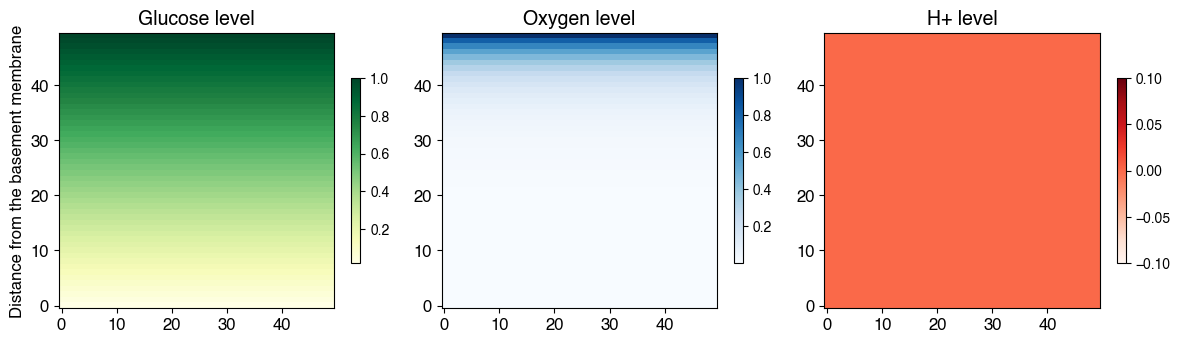

In [ ]:
# metabolite fields
glucose_level = np.zeros(ca_grid.shape[:2])
oxygen_level = np.zeros(ca_grid.shape[:2])
acidity_level = np.zeros(ca_grid.shape[:2])

# extract metabolite level from ca_grid
for i in range(ca_grid.shape[0]):
    for j in range(ca_grid.shape[1]):
        _, metabolites = ca_grid[i][j]
        glucose_level[i, j] = metabolites[0]  
        oxygen_level[i, j] = metabolites[1]   
        acidity_level[i, j] = metabolites[2]  

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Glucose
im1 = axs[0].imshow(glucose_level, cmap='YlGn', origin='lower')
axs[0].set_title('Glucose level', fontsize=14)
axs[0].set_xlabel('')
axs[0].set_ylabel('Distance from the basement membrane', fontsize=12)
#plt.colorbar(im1, ax=axs[0])
cbar1 = plt.colorbar(im1, ax=axs[0], shrink=0.5)
axs[0].tick_params(axis='both', labelsize=12)

# Oxygen
im2 = axs[1].imshow(oxygen_level, cmap='Blues', origin='lower')
axs[1].set_title('Oxygen level', fontsize=14)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
#plt.colorbar(im2, ax=axs[1])
cbar2 = plt.colorbar(im2, ax=axs[1], shrink=0.5)
axs[1].tick_params(axis='both', labelsize=12)

# Acidity
im3 = axs[2].imshow(acidity_level, cmap='Reds', origin='lower')
axs[2].set_title('H+ level', fontsize=14)
axs[2].set_xlabel('')
axs[2].set_ylabel('')
#plt.colorbar(im3, ax=axs[2])
cbar3 = plt.colorbar(im3, ax=axs[2], shrink=0.5)
axs[2].tick_params(axis='both', labelsize=12)

plt.tight_layout()
# plt.savefig("figures/metabolites.png",bbox_inches='tight', dpi=300)
plt.show()

## Analyzing the pattern frequencies

In [11]:
data = pd.read_csv('stats.csv')
data.sort_values(by='alpha', inplace=True)
data.set_index('alpha', inplace=True)

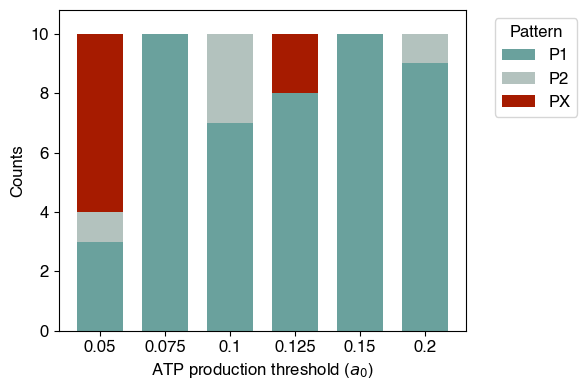

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

bar_width = 0.7

indices = np.arange(len(data))

p1 = ax.bar(indices, data['P1'], bar_width, label='P1', color="#6aa19d")
p2 = ax.bar(indices, data['P2'], bar_width, bottom=data['P1'], label='P2', color="#b3c2be")
p3 = ax.bar(indices, data['PX'], bar_width, bottom=data['P1'] + data['P2'], label='PX', color="#a61b00")

ax.set_xlabel(r'ATP production threshold ($a_0$)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('')

ax.set_xticks(indices)
ax.set_xticklabels(data.index, rotation=0, fontsize=12)
ax.set_ylim([0, 10.8])
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Pattern', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.savefig("figures/cell_counts.png",bbox_inches='tight', dpi=300)
plt.show()

## The effects of ATP production thresholds on development rate

In [ ]:
folder_path = 'cellcounts'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

developmentRate = {}
carcinoT = {}

In [19]:
for file_name in csv_files:

    file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(file_path)
    
    df['total_cells'] = 2500 - df['empty']
    df['invasive_percent'] =  (df['total_cells'] - df['normal']) / df['total_cells']

    
    T = df[df['invasive_percent'] >= 0.95]['Iteration'].min()
    T = T * (10**-3)
    R = T ** -1
    developmentRate[file_name] = R
    carcinoT[file_name] = T

    df.to_csv(file_path, index=False)

In [20]:
df = pd.DataFrame(list(developmentRate.items()), columns=['filename', 'R'])

df['group'] = df['filename'].str.extract(r'(^\d+\.\d+)')  
df['run'] = df['filename'].str.extract(r'_(run\d+)_') 

df = df[['group', 'run', 'R']]

mean_std_df = df.groupby('group')['R'].agg(['mean', 'std', 'count']).reset_index()
mean_std_df['standard_error'] = mean_std_df['std'] / np.sqrt(mean_std_df['count'])

mean_std_df.rename(columns={'mean': 'mean_R', 'std': 'std_R'}, inplace=True)

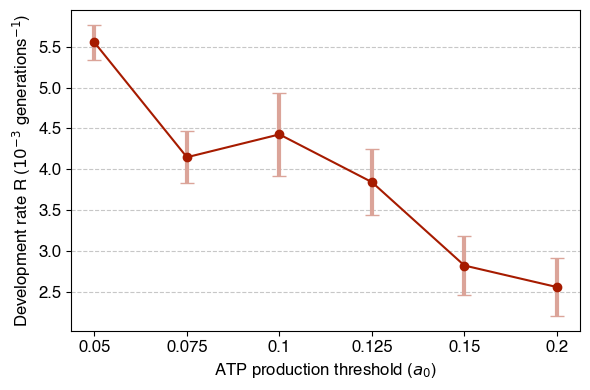

In [ ]:
plt.figure(figsize=(6, 4))

plt.errorbar(mean_std_df['group'], mean_std_df['mean_R'], 
             yerr=mean_std_df['standard_error'], 
             fmt='o', 
             color='#a61b00', 
             ecolor='#dba499', 
             elinewidth=3, 
             capsize=5,
             label='Mean R with SE')

plt.plot(mean_std_df['group'], mean_std_df['mean_R'], 
         color='#a61b00', linestyle='-', linewidth=1.5)

plt.xlabel(r'ATP production threshold ($a_0$)', fontsize=12)
plt.ylabel(r'Development rate R ($10^{-3}$ generations$^{-1}$)', fontsize=12)
plt.title('', fontsize=14)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.legend()
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.savefig("figures/R_per_ATP.png",bbox_inches='tight', dpi=300)
plt.show()